In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
# from zipfile import ZipFile

# with ZipFile('data/train/train.zip', 'r') as zipObj:
   
#    zipObj.extractall('data/train/') 


# with ZipFile('data/test/test.zip', 'r') as zipObj:
   
#    zipObj.extractall('data/test/') 


# with ZipFile('data/sample_submission/sample_submission.csv.zip', 'r') as zipObj:
   
#    zipObj.extractall('data/sample_submission/') 

In [3]:
labels_csv = pd.read_csv("data/labels.csv")

<AxesSubplot:>

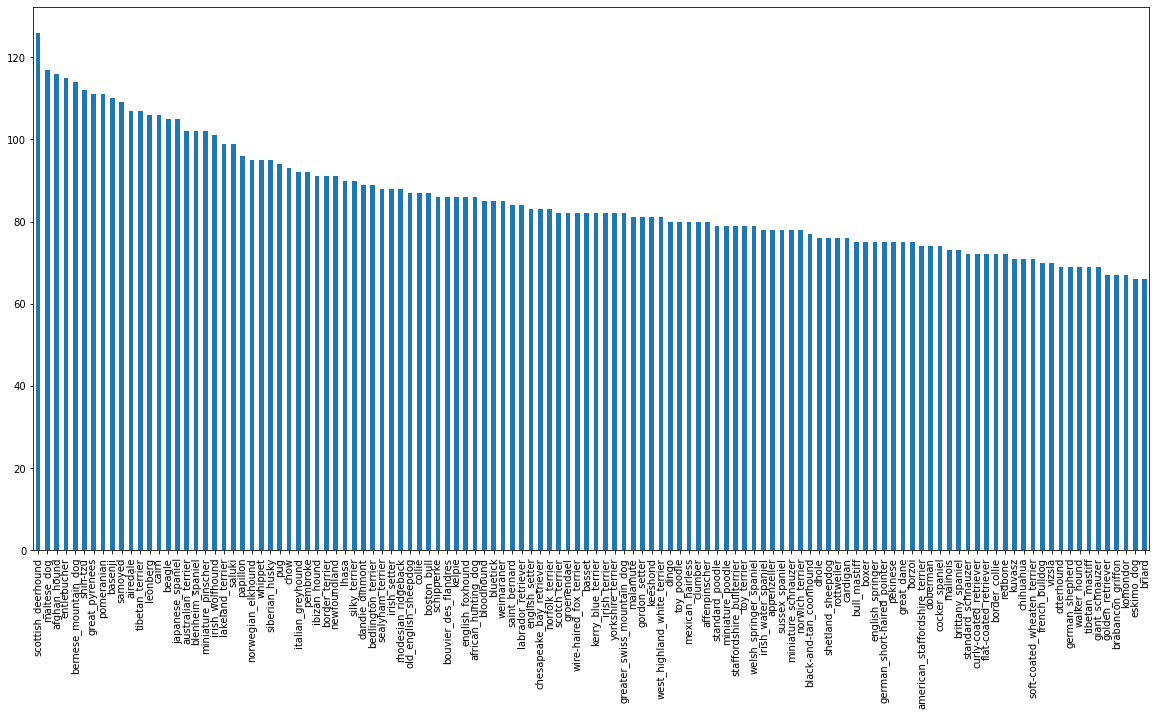

In [4]:
%matplotlib inline
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [5]:
from IPython.display import Image

filenames = ['data/train/' + fname + '.jpg' for fname in labels_csv['id']]

In [6]:
import os
if len(os.listdir("data/train/"))-1 == len(filenames):
  print('Filenames amounts match')
else:
  print('Filenames amounts do not match')

Filenames amounts match


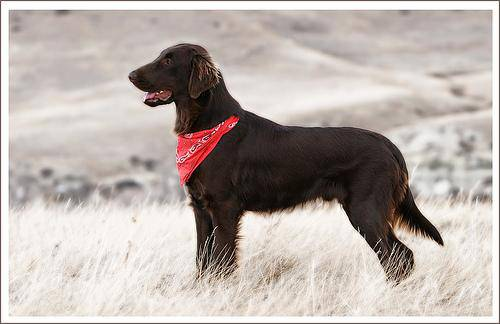

In [7]:
Image(filenames[1011])

In [8]:
import numpy as np
labels = labels_csv["breed"].to_numpy()

unique_breeds = np.unique(labels)
len(unique_breeds)

120